# LSTM

First AI model inspired by:
- https://www.youtube.com/watch?v=jR0phoeXjrc&ab_channel=VenelinValkov
- https://www.youtube.com/watch?v=PCgrgHgy26c&ab_channel=VenelinValkov

In [1]:
import sys, os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
DATE = "2023_04_14"
DATA_FOLDER = os.path.join("../data/android_app/", DATE)

DATA_FILES = [file for file in os.listdir(DATA_FOLDER) if os.path.isfile(os.path.join(DATA_FOLDER, file)) and file.endswith(".txt")]

## Load Data

In [3]:
X = pd.read_csv(os.path.join(DATA_FOLDER, DATE + ".csv"))
y = pd.read_csv(os.path.join(DATA_FOLDER,DATE + ".labels"))

In [4]:
X.head()

,file,index,ax,ay,az
0,DATA43.txt,0,0.220267,0.172383,9.959879
1,DATA43.txt,1,0.181959,0.105345,10.046070
2,DATA43.txt,2,0.325611,0.220267,9.768343
3,DATA43.txt,3,0.277727,0.105345,9.787497
4,DATA43.txt,4,0.287304,0.220267,9.950302


In [5]:
y.head()

,file,label
0,DATA1.txt,speed_bump
1,DATA2.txt,speed_bump
2,DATA3.txt,speed_bump
3,DATA4.txt,speed_bump
4,DATA5.txt,speed_bump


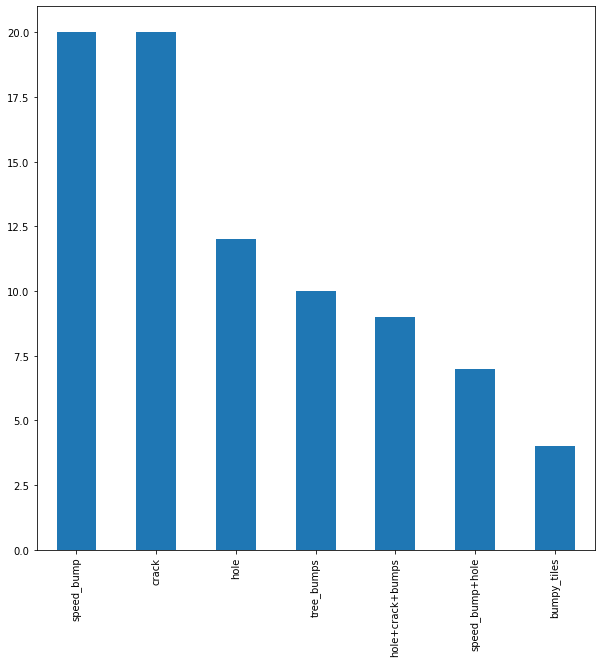

In [6]:
plt.figure(figsize=(10,10))
y.label.value_counts().plot(kind="bar")
# plt.xticks(rotation=45)
plt.show()

## Preprocessing

### Convert file to integer

In [7]:
def fileToInt(file):
    file = file[4:] # Remove "DATA"
    file = file[:len(file)-4] # Remove ".txt"
    return int(file)

In [8]:
X["file"] = X["file"].apply(fileToInt)
y["file"] = y["file"].apply(fileToInt)

### Convert labels to integer

In [9]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(y.label)
y["encoded_label"] = encoded_labels

In [10]:
label_encoder.classes_

array(['bumpy_tiles', 'crack', 'hole', 'hole+crack+bumps', 'speed_bump',
       'speed_bump+hole', 'tree_bumps'], dtype=object)

In [11]:
y.head()

,file,label,encoded_label
0,1,speed_bump,4
1,2,speed_bump,4
2,3,speed_bump,4
3,4,speed_bump,4
4,5,speed_bump,4


### Create sequences

In [12]:
FEATURE_COLUMNS = X.columns.tolist()

In [13]:
X.file.value_counts()

71    9488
72    7856
74    7855
76    7826
67    7815
      ... 
14    1436
24    1427
22    1395
16    1292
20    1288
Name: file, Length: 82, dtype: int64

In [14]:
sequence_length = max(X.file.value_counts())

In [15]:
sequences = []
sequences_encoded_labels = []

for file, group in X.groupby("file"):
    sequence_features = group[FEATURE_COLUMNS]
    encoded_label = y[y.file == file].iloc[0].encoded_label
    
    last_index = sequence_features.index[len(sequence_features)-1]

    # Sequences must have the same length -> add padding...
    if len(sequence_features) < sequence_length:
        padding_length = sequence_length - len(sequence_features)
        new_rows = pd.DataFrame({"file": [file for i in range(padding_length)], "index": [i+last_index+1 for i in range(padding_length)], "ax": [0 for i in range(padding_length)], "ay": [0 for i in range(padding_length)], "az": [0 for i in range(padding_length)]}, index=[i+last_index+1 for i in range(padding_length)])
        sequence_features = pd.concat([sequence_features,new_rows]).reset_index(drop=True)

    sequences.append((sequence_features, encoded_label))
    sequences_encoded_labels.append(encoded_label)

In [16]:
sequences[0]

(      file   index        ax        ay         az
 0        1       0  0.076614 -0.938527  10.611102
 1        1       1 -0.114922  0.478840  11.166556
 2        1       2 -0.258574  0.794875   9.988609
 3        1       3  0.325611 -0.555455  10.046070
 4        1       4  0.488417  0.181959   9.548077
 ...    ...     ...       ...       ...        ...
 9483     1  222351  0.000000  0.000000   0.000000
 9484     1  222352  0.000000  0.000000   0.000000
 9485     1  222353  0.000000  0.000000   0.000000
 9486     1  222354  0.000000  0.000000   0.000000
 9487     1  222355  0.000000  0.000000   0.000000
 
 [9488 rows x 5 columns],
 4)

## Create Train/Test Datasets

In [17]:
from sklearn.model_selection import train_test_split

train_sequences, test_sequences = train_test_split(sequences, test_size=0.2,shuffle=True, random_state=66, stratify=sequences_encoded_labels)
print(f"Train sequences: {len(train_sequences)} | Test sequences: {len(test_sequences)}")

Train sequences: 65 | Test sequences: 17


In [18]:
import torch
from torch.utils.data import Dataset

class ObstacleDataset(Dataset):

    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, encoded_label = self.sequences[idx]
        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            encoded_label=torch.tensor(encoded_label).long()
        )

In [19]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from multiprocessing import cpu_count

class ObstacleDataModule(pl.LightningDataModule):

    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = ObstacleDataset(self.train_sequences)
        self.test_dataset = ObstacleDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )

In [20]:
N_EPOCHS = 250
BATCH_SIZE = 64

data_module = ObstacleDataModule(train_sequences, test_sequences, BATCH_SIZE)

## Create Model

In [21]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SequenceModel(nn.Module):

    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.785
        )
        self.classifier = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]
        return self.classifier(out)

In [22]:
from torchmetrics.classification import MulticlassAccuracy

class ObstaclePredictor(pl.LightningModule):

    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = MulticlassAccuracy(num_classes=len(label_encoder.classes_), average="weighted", top_k=1)

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        encoded_labels = batch["encoded_label"]
        loss, outputs = self.forward(sequences, encoded_labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = self.accuracy(predictions, encoded_labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)

        return {"loss": loss, "accuracy": step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        encoded_labels = batch["encoded_label"]
        loss, outputs = self.forward(sequences, encoded_labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = self.accuracy(predictions, encoded_labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)

        return {"loss": loss, "accuracy": step_accuracy}
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        encoded_labels = batch["encoded_label"]
        loss, outputs = self.forward(sequences, encoded_labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = self.accuracy(predictions, encoded_labels)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)

        return {"loss": loss, "accuracy": step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

In [23]:
model = ObstaclePredictor(
    n_features=len(FEATURE_COLUMNS),
    n_classes=len(label_encoder.classes_)
)

In [24]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [25]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="surface")

trainer = pl.Trainer(
    logger=logger,
    # checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    # gpus=1,
    # progress_bar_refresh_rate=30
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model, data_module)


  | Name      | Type               | Params
-------------------------------------------------
0 | model     | SequenceModel      | 1.3 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.295     Total estimated model params size (MB)
2023-05-01 14:52:33.898763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 14:52:34.155390: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn the

Sanity Checking: 0it [00:00, ?it/s]

/home/fabien/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

: 

: 